In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from odtlearn.flow_oct import FlowOCT, BendersOCT
from odtlearn.utils.binarize import binarize

# `FlowOCT` Examples

## Example 0: Binarization

The following example shows how to binarize a dataset with categorical and integer features using the built-in function `binarize`.

In [2]:
number_of_child_list = [1, 2, 4, 3, 1, 2, 4, 3, 2, 1]
age_list = [10, 20, 40, 30, 10, 20, 40, 30, 20, 10]
race_list = [
    "Black",
    "White",
    "Hispanic",
    "Black",
    "White",
    "Black",
    "White",
    "Hispanic",
    "Black",
    "White",
]
sex_list = ["M", "F", "M", "M", "F", "M", "F", "M", "M", "F"]
df = pd.DataFrame(
    list(zip(sex_list, race_list, number_of_child_list, age_list)),
    columns=["sex", "race", "num_child", "age"],
)

In [3]:
df_enc = binarize(
    df, categorical_cols=["sex", "race"], integer_cols=["num_child", "age"]
)
df_enc

,sex_M,race_Black,race_Hispanic,race_White,num_child_1,num_child_2,num_child_3,num_child_4,age_10,age_20,age_30,age_40
0,1,1,0,0,1,1,1,1,1,1,1,1
1,0,0,0,1,0,1,1,1,0,1,1,1
2,1,0,1,0,0,0,0,1,0,0,0,1
3,1,1,0,0,0,0,1,1,0,0,1,1
4,0,0,0,1,1,1,1,1,1,1,1,1
5,1,1,0,0,0,1,1,1,0,1,1,1
6,0,0,0,1,0,0,0,1,0,0,0,1
7,1,0,1,0,0,0,1,1,0,0,1,1
8,1,1,0,0,0,1,1,1,0,1,1,1
9,0,0,0,1,1,1,1,1,1,1,1,1


## Example 1: Varying `depth` and `_lambda`
In this part, we study a simple example and investigate different parameter combinations to provide intuition on how they affect the structure of the tree.

First we generate the data for our example. The diagram within the code block shows the training dataset. Our dataset has two binary features (X1 and X2) and two class labels (+1 and -1).

In [4]:
from odtlearn.datasets import flow_oct_example

"""
    X2
    |               |
    |               |
    1    + +        |    -
    |               |   
    |---------------|-------------
    |               |
    0    - - - -    |    + + +
    |    - - -      |
    |______0________|_______1_______X1
"""


X, y = flow_oct_example()

### Tree with `depth = 1`

In the following, we fit a classification tree of depth 1, i.e., a tree with a single branching node and two leaf nodes.

In [5]:
stcl = FlowOCT(depth=1)
stcl.fit(X, y)

Restricted license - for non-production use only - expires 2023-10-25


FlowOCT(depth=1,time_limit=60,num_threads=None,verbose=False)

In [6]:
predictions = stcl.predict(X)
print(f'Optimality gap is {stcl._model.getAttr("MIPGap")}')
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

Optimality gap is 0.0
In-sample accuracy is 0.7692307692307693


As we can see above, we find the optimal tree and the in-sample accuracy is 76%.

ODTlearn provides two different ways of visualizing the structure of the tree. The first method prints the structure of the tree in the console:

In [7]:
stcl.print_tree()

#########node  1
branch on X_0
#########node  2
leaf 0
#########node  3
leaf 1


The second method plots the structure of the tree using `matplotlib`:

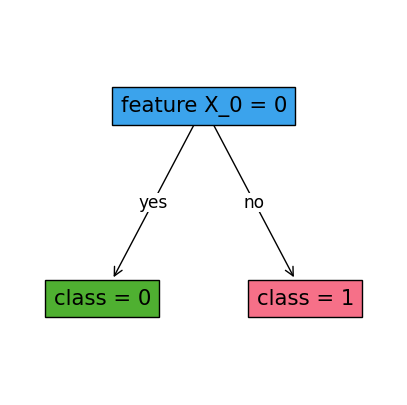

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
stcl.plot_tree(ax=ax)
plt.show()

### Tree with `depth = 2`

Now we increase the depth of the tree to achieve higher accuracy.

In [9]:
stcl = FlowOCT(depth=2)
stcl.fit(X, y)

FlowOCT(depth=2,time_limit=60,num_threads=None,verbose=False)

In [10]:
print(f'Optimality gap is {stcl._model.getAttr("MIPGap")}')
predictions = stcl.predict(X)
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

Optimality gap is 0.0
In-sample accuracy is 1.0


As we can see, with depth 2, we can achieve 100% in-sample accuracy.

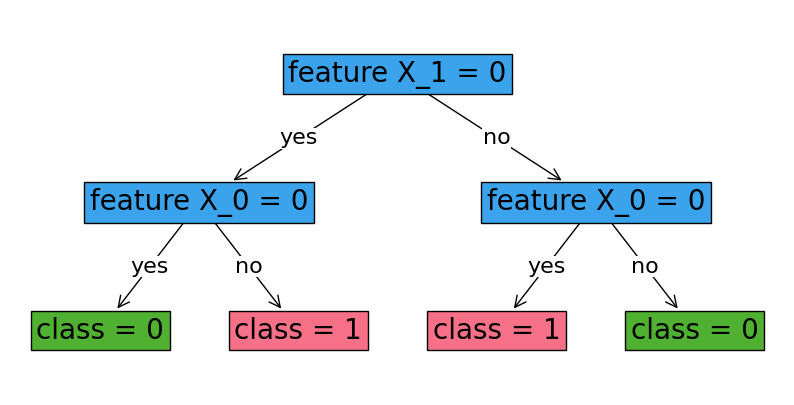

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))
stcl.plot_tree(ax=ax, fontsize=20)
plt.show()

### Tree with `depth=2` and Positive `_lambda`

As we saw in the above example, with depth 2, we can fully classify the training data. However if we add a regularization term with a high enough value of `_lambda`, we can justify pruning one of the branching nodes to get a sparser tree. In the following, we observe that as we increase `_lambda` from 0 to 0.51, one of the branching nodes gets pruned and as a result, the in-sample accuracy drops to 92%.

In [12]:
stcl = FlowOCT(depth=2, _lambda=0.51)
stcl.fit(X, y)

FlowOCT(depth=2,time_limit=60,num_threads=None,verbose=False)

In [13]:
predictions = stcl.predict(X)
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

In-sample accuracy is 0.9230769230769231


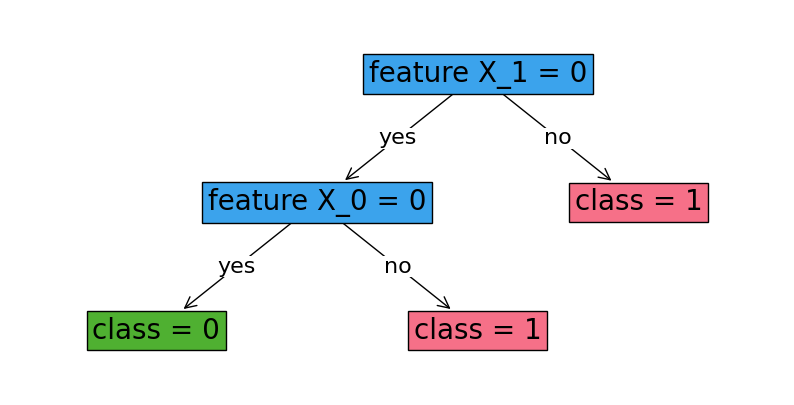

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
stcl.plot_tree(ax=ax, fontsize=20)
plt.show()

## Example 2: Different Objective Functions

In the following, we have a toy example with an imbalanced data, with the positive class being the minority class.

In [15]:
'''
    X2
    |               | 
    |               |
    1    + - -      |    -
    |               |   
    |---------------|--------------
    |               |
    0    - - - +    |    - - -
    |    - - - -    |
    |______0________|_______1_______X1
'''
X = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],
              [1,0],[1,0],[1,0],
              [1,1],
              [0,1],[0,1],[0,1]])
y = np.array([0,0,0,0,0,0,0,1,
              0,0,0,
              0,
              1,0,0])

### Tree with classification accuracy objective

In [16]:
stcl_acc = BendersOCT(depth=2, obj_mode="acc", verbose=False)
stcl_acc.fit(X, y)
predictions = stcl_acc.predict(X)
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

In-sample accuracy is 0.8666666666666667


In [17]:
stcl_acc.print_tree()

#########node  1
branch on X_0
#########node  2
branch on X_1
#########node  3
branch on X_1
#########node  4
leaf 0
#########node  5
leaf 0
#########node  6
leaf 0
#########node  7
leaf 0


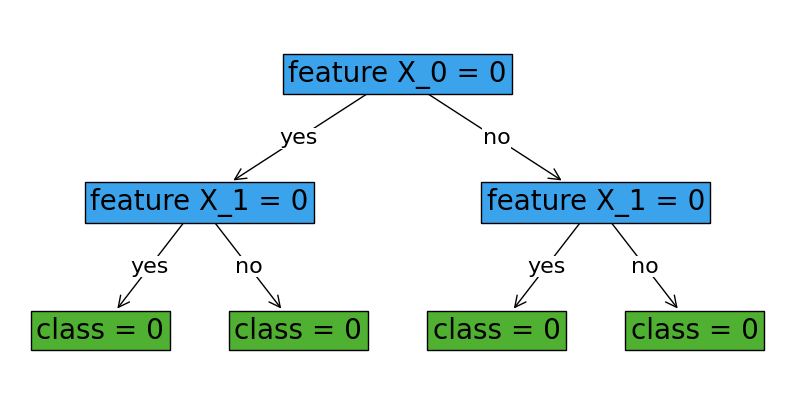

In [18]:
fig, ax = plt.subplots(figsize=(10, 5)) 
stcl_acc.plot_tree(ax=ax, fontsize=20)
plt.show()

### Tree with Balanced Classification Accuracy Objective

In [19]:
stcl_balance = FlowOCT(
    depth=2,
    obj_mode="balance",
    _lambda=0,
    verbose=False,
)
stcl_balance.fit(X, y)
predictions = stcl_balance.predict(X)
print(f"In-sample accuracy is {np.sum(predictions==y)/y.shape[0]}")

In-sample accuracy is 0.8


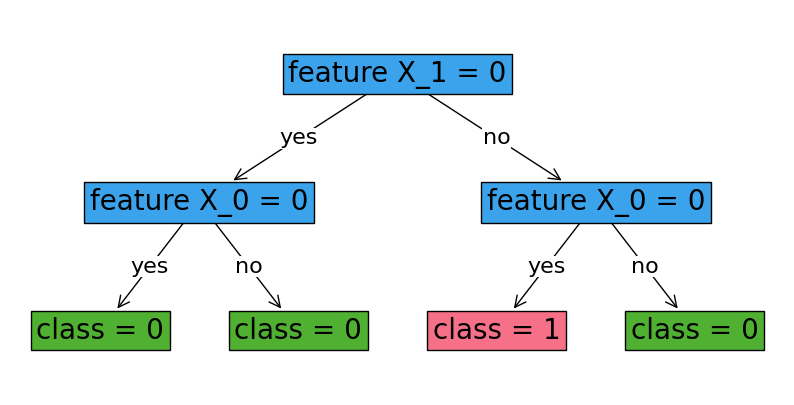

In [20]:
fig, ax = plt.subplots(figsize=(10, 5)) 
stcl_balance.plot_tree(ax=ax, fontsize=20)
plt.show()

As we can see, when we maximize accuracy, i.e., when `obj_mode = 'acc'`, the optimal tree is just a single node without branching, predicting the majority class for the whole dataset. But when we change the objective mode to balanced accuracy, we account for the minority class by sacrificing the overal accuracy.

## Example 3: UCI Data Example

In this section, we fit a tree of depth 3 on a real world dataset called the [`balance` dataset](https://archive.ics.uci.edu/ml/datasets/Balance+Scale) from the UCI Machine Learning repository. 

In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from odtlearn.datasets import balance_scale_data

In [22]:
# read data
data = balance_scale_data()
print(f"shape{data.shape}")
data.columns

shape(625, 21)


Index(['V2.1', 'V2.2', 'V2.3', 'V2.4', 'V2.5', 'V3.1', 'V3.2', 'V3.3', 'V3.4',
       'V3.5', 'V4.1', 'V4.2', 'V4.3', 'V4.4', 'V4.5', 'V5.1', 'V5.2', 'V5.3',
       'V5.4', 'V5.5', 'target'],
      dtype='object')

In [23]:
y = data.pop("target")

X_train, X_test, y_train, y_test = train_test_split(
    data, y, test_size=0.33, random_state=42
)

In [24]:
stcl = BendersOCT(depth=3, time_limit=60, num_threads=None, obj_mode="acc")

stcl.fit(X_train, y_train)

BendersOCT(depth=3,time_limit=60,num_threads=None,verbose=False)

In [25]:
stcl.print_tree()

#########node  1
branch on V3.5
#########node  2
branch on V5.1
#########node  3
branch on V2.1
#########node  4
branch on V4.1
#########node  5
branch on V2.1
#########node  6
branch on V2.2
#########node  7
branch on V4.1
#########node  8
leaf 3
#########node  9
leaf 2
#########node  10
leaf 2
#########node  11
leaf 3
#########node  12
leaf 2
#########node  13
leaf 2
#########node  14
leaf 3
#########node  15
leaf 2


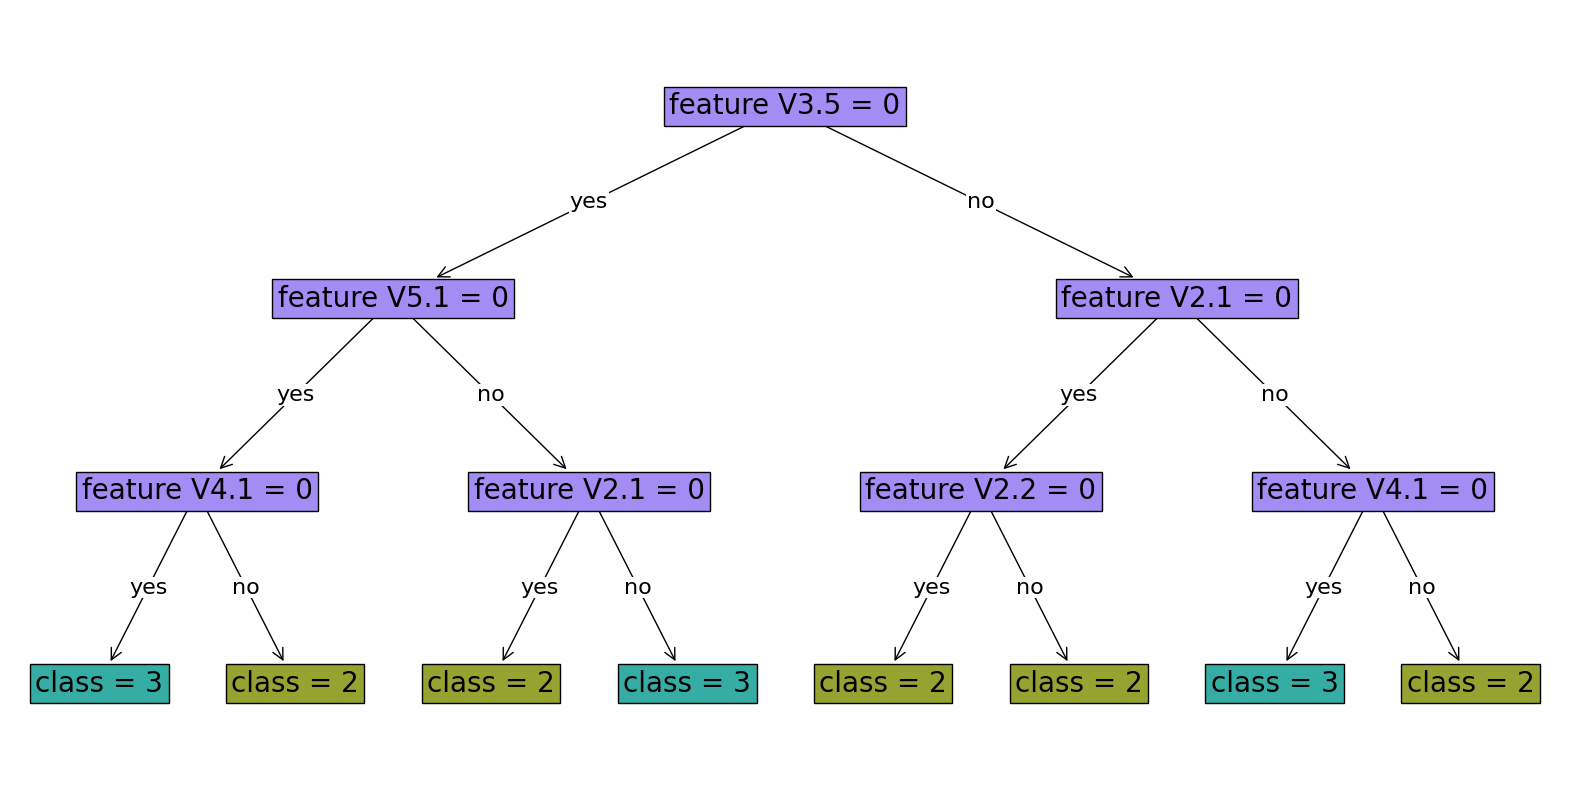

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
stcl.plot_tree(ax=ax, fontsize=20, color_dict={"node": None, "leaves": []})
plt.show()

In [27]:
test_pred = stcl.predict(X_test)
print('The out-of-sample accuracy is {}'.format(np.sum(test_pred==y_test)/y_test.shape[0]))

The out-of-sample accuracy is 0.7004830917874396


## References
* Dua, D. and Graff, C. (2019). [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml). Irvine, CA: University of California, School of Information and Computer Science.
* Aghaei, S., Gómez, A., & Vayanos, P. (2021). Strong optimal classification trees. arXiv preprint arXiv:2103.15965. https://arxiv.org/abs/2103.15965.